In [1]:
from tqdm.notebook import tqdm_notebook

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute, transpile, assemble, IBMQ
from qiskit.utils import QuantumInstance
from qiskit.circuit import Parameter,ParameterVector
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import EfficientSU2, ZZFeatureMap
from qiskit.opflow import Z, X, I, StateFn, CircuitStateFn, SummedOp
from qiskit.opflow.gradients import Gradient, NaturalGradient, QFI, Hessian
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.algorithms.classifiers import VQC
from sklearn.preprocessing import OneHotEncoder
from qiskit.providers.aer.noise import NoiseModel
from qiskit.algorithms.optimizers import SPSA, GradientDescent, QNSPSA, ADAM
from qiskit.tools.monitor import job_monitor

import numpy as np
import itertools as itr
import matplotlib.pyplot as plt
from qiskit_machine_learning.runtime import TorchRuntimeClient, TorchRuntimeResult

ACC_COUNT = 10

## Amp
DIR_val_train_amp = "Encode_data/amp_enc_data_set_trainning_values.csv"
DIR_cls_train_amp = "Encode_data/amp_enc_data_set_trainning_classes.csv"
DIR_val_test_amp = "Encode_data/amp_enc_data_set_test_values.csv"
DIR_cls_test_amp = "Encode_data/amp_enc_data_set_test_classes.csv"

## Ang
DIR_val_train_ang = "Encode_data/ang_enc_data_set_trainning_values.csv"
DIR_cls_train_ang = "Encode_data/ang_enc_data_set_trainning_classes.csv"
DIR_val_test_ang = "Encode_data/ang_enc_data_set_test_values.csv"
DIR_cls_test_ang = "Encode_data/ang_enc_data_set_test_classes.csv"\

provider = IBMQ.enable_account("dcbfead05af57561bd8ede02e3ba82d103c40683442fd5742116c4cc079999d49e865bc6b579a2f21186e8b7fb732c7161712ff6f41fcd9ea4c820e6d4d53d00")
backend = provider.get_backend('ibmq_manila')
noise_model = NoiseModel.from_backend(backend)

quantum_instance = QuantumInstance(backend=Aer.get_backend('qasm_simulator'), 
                                   shots=1024,
                                   noise_model=noise_model)

In [2]:
def get_encode(file):
    """
     Funcao responsavel pelo encoding (amplitude)
        Input :: 
        ### file : File dir
        Output :: 
        #### data_enc : Valores para o encode (numpy array)
    """
    return np.genfromtxt(file, delimiter=";")

def get_mat(model, data_points, labels):
    ret = np.zeros((2,2))
    predict = model.predict(data_points)
    for p, r in zip(predict, labels):
        if np.array_equal(p,r) and r[0] == 1:
            ret[0,0] += 1
        elif not np.array_equal(p,r) and r[0] == 1:
            ret[1,0] += 1
        elif np.array_equal(p,r) and r[0] == 0:
            ret[1,1]+=1
        elif not np.array_equal(p,r) and r[0] == 0:
            ret[0,1] += 1
    return ret, len(data_points)

def get_stats(mat):
    """
    - Recall, True Positive Rate ou Sensitividade - TPR
        Mede uma proporção dos valores que são de facto 
        positivos e que foram preditos corretamente.
        
    - Precision
        Mede a proporção de predições positivas que estão corretas,
        ou seja, quão bem o modelo predisse os valores positivos.
        
    - False Positive Rate - FPR 
        Indica quanto da classe negativa foi 
        predito incorretamente.
    """
    
    stats ={}
    st = ["TPR", "TNR", "Precision", "FPR", "FNR"]
    stats[st[0]] = mat[0,0]/(mat[0,0]*mat[1,0])
    stats[st[1]] = mat[1,1]/(mat[1,1]*mat[0,1])
    stats[st[2]] = mat[0,0]/(mat[0,0]*mat[0,1])
    stats[st[3]] = mat[0,1]/(mat[0,1]*mat[1,1])
    stats[st[4]] = mat[1,1]/(mat[1,1]*mat[0,0])
    return stats

In [4]:
n_qubits = 3

encoding = RawFeatureVector(2**n_qubits)

#2 Fica num platue de cost = 2
ansatz = EfficientSU2(n_qubits, entanglement='full', reps=4, 
                        insert_barriers=True, name="U(\u03B8)", 
                        parameter_prefix="\u03B8")

qc = encoding.compose(ansatz)
qc.measure_all()

In [5]:
train_data_amp = get_encode(DIR_val_train_amp)
train_labels_amp = get_encode(DIR_cls_train_amp)

test_data_amp = get_encode(DIR_val_test_amp)
test_labels_amp = get_encode(DIR_cls_test_amp)

encoder = OneHotEncoder()
train_labels_oh_amp = encoder.fit_transform(train_labels_amp.reshape(-1, 1)).toarray()
test_labels_oh_amp = encoder.fit_transform(test_labels_amp.reshape(-1, 1)).toarray()

print("Training data set: ", len(train_labels_amp))
print("Testing data set:  ", len(test_labels_amp))

Training data set:  180
Testing data set:   54


In [6]:
initial_point = np.random.random(ansatz.num_parameters)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Cannot compute gradient operator! Continuing without gradients!


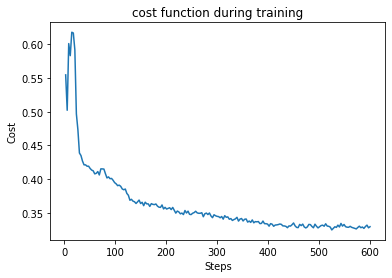

  0%|          | 0/400 [00:00<?, ?it/s]

Cannot compute gradient operator! Continuing without gradients!


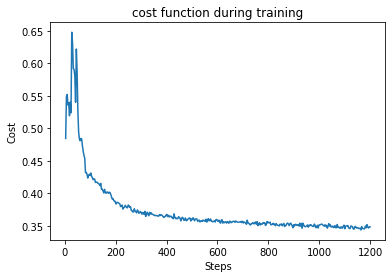

  0%|          | 0/600 [00:00<?, ?it/s]

Cannot compute gradient operator! Continuing without gradients!


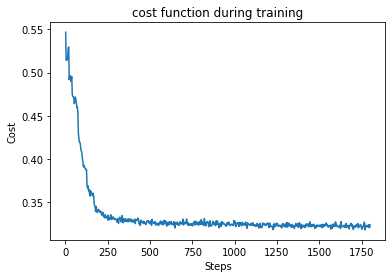

  0%|          | 0/800 [00:00<?, ?it/s]

Cannot compute gradient operator! Continuing without gradients!


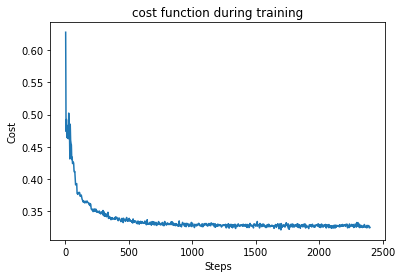

  0%|          | 0/1000 [00:00<?, ?it/s]

Cannot compute gradient operator! Continuing without gradients!


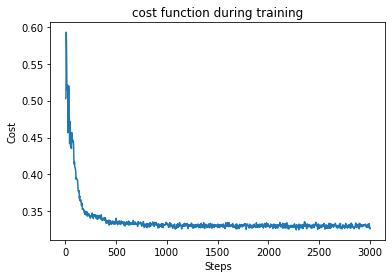

NameError: name 'json' is not defined

In [7]:
maxiter=200
def store_intermediate_result(evaluation, parameter, cost, stepsize, accept):
    evaluations.append(evaluation)
    parameters.append(parameter)
    costs.append(cost)
    p.update(1)

dic_amp = {}
t = tqdm_notebook(total=5)    
while maxiter <= 1000:    
    ### Progress Bar
    p = tqdm_notebook(total=maxiter, leave=False)
    
    dic_amp[maxiter] = {}
    dic_amp[maxiter]["score"] = {}
    
    parameters = []
    costs = []
    evaluations = []
    
    vqc = VQC(feature_map=encoding,
              ansatz=ansatz,
              loss='squared_error',
              optimizer=SPSA(maxiter=maxiter, callback=store_intermediate_result),
              initial_point=initial_point,
              quantum_instance=Aer.get_backend('qasm_simulator'))

    vqc.fit(train_data_amp, train_labels_oh_amp)
    score_train = vqc.score(train_data_amp, train_labels_oh_amp)
    dic_amp[maxiter]["score"]["trainning"] = score_train
    
    fig = plt.figure()
    plt.plot(evaluations, costs)
    plt.xlabel('Steps')
    plt.ylabel('Cost')
    plt.title("cost function during training")
    plt.show()

    score_tst = vqc.score(test_data_amp, test_labels_oh_amp)
    dic_amp[maxiter]["score"]["test"] = score_tst
    
    mat, lng = get_mat(vqc, test_data_amp, test_labels_oh_amp)
    dic_amp[maxiter]["mat"] = mat.tolist()
    
    stats = get_stats(mat)
    dic_amp[maxiter]["stats"] = stats
    
    dic_amp[maxiter]["parameters"] = parameters[-1].tolist()
    
    maxiter += 200
    t.update(1)
    
with open('amp_ce_3Qbits_Noise.json', 'w', encoding ='utf8') as json_file:
    json.dump(dic_amp, json_file, ensure_ascii = True)

In [ ]:
%%script echo skip
fig = plt.figure()
plt.plot(evaluations, costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.title("cost function during training")
plt.show()

print("Labels: ", test_labels_oh_amp)
print("Predict: ", vqc.predict(test_data_amp))
print("Score: ", vqc.score(test_data_amp, test_labels_oh_amp))

In [ ]:
dic_amp

In [ ]:
train_data_ang = get_encode(DIR_val_train_ang)
train_labels_ang = get_encode(DIR_cls_train_ang)

test_data_ang= get_encode(DIR_val_test_ang)
test_labels_ang = get_encode(DIR_cls_test_ang)

encoder = OneHotEncoder()
train_labels_oh_ang = encoder.fit_transform(train_labels_ang.reshape(-1, 1)).toarray()
test_labels_oh_ang = encoder.fit_transform(test_labels_ang.reshape(-1, 1)).toarray()

In [ ]:
n_qubits = 3

encoding = ZZFeatureMap(feature_dimension=n_qubits, reps=3)

ansatz = EfficientSU2(n_qubits, entanglement='full', reps=4, 
                        insert_barriers=True, name="U(\u03B8)", 
                        parameter_prefix="\u03B8")

qc = encoding.compose(ansatz)
qc.measure_all()

In [ ]:
maxiter=200
def store_intermediate_result(evaluation, parameter, cost, stepsize, accept):
    evaluations.append(evaluation)
    parameters.append(parameter)
    costs.append(cost)
    p.update(1)

dic_ang = {}
t = tqdm_notebook(total=5)    
while maxiter <= 1000:    
    ### Progress Bar
    p = tqdm_notebook(total=maxiter, leave=False)
    
    dic_ang[maxiter] = {}
    
    dic_ang[maxiter]["score"] = {}
    parameters = []
    costs = []
    evaluations = []
    
    vqc = VQC(feature_map=encoding,
              ansatz=ansatz,
              loss='squared_error',
              optimizer=SPSA(maxiter=maxiter, callback=store_intermediate_result),
              initial_point=initial_point,
              quantum_instance=Aer.get_backend('qasm_simulator'))

    vqc.fit(train_data_ang, train_labels_oh_ang)
    score_train = vqc.score(train_data_ang, train_labels_oh_ang)
    dic_ang[maxiter]["score"]["trainning"] = score_train
    
    fig = plt.figure()
    plt.plot(evaluations, costs)
    plt.xlabel('Steps')
    plt.ylabel('Cost')
    plt.title("cost function during training")
    plt.show()
    
    score_tst = vqc.score(test_data_ang, test_labels_oh_ang)
    dic_ang[maxiter]["score"]["test"] = score_tst
    
    mat, lng = get_mat(vqc, test_data_ang, test_labels_oh_ang)
    dic_ang[maxiter]["mat"] = mat.tolist()
    
    stats = get_stats(mat)
    dic_ang[maxiter]["stats"] = stats
    
    dic_ang[maxiter]["parameters"] = parameters[-1].tolist()
    
    maxiter += 200
    t.update(1)
    
with open('ang_ce_3Qbits_Noise.json', 'w', encoding ='utf8') as json_file:
    json.dump(dic_ang, json_file, ensure_ascii = True)

In [ ]:
%%script echo skip

fig = plt.figure()
plt.plot(evaluations, costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.title("cost function during training")
plt.show()

print("Labels: ", test_labels_oh_ang)
print("Predict: ", vqc.predict(test_data_ang))
print("Score: ", vqc.score(test_data_ang, test_labels_oh_ang))

In [ ]:
epochs = [200, 400, 600, 800, 1000]
trainning_scores_ang = []

test_scores_ang = []
test_TNR_ang = []
test_TPR_ang = []

for epoch in epochs:
    trainning_scores_ang += [dic_ang[epoch]["score"]["trainning"]]
 
    test_scores_ang += [dic_ang[epoch]["score"]["test"]]
    test_TNR_ang += [dic_ang[epoch]["stats"]["TNR"]]
    test_TPR_ang += [dic_ang[epoch]["stats"]["TPR"]]

In [ ]:
epochs = [200, 400, 600, 800, 1000]
trainning_scores_amp = []

test_scores_amp = []
test_TNR_amp = []
test_TPR_amp = []

for epoch in epochs:
    trainning_scores_amp += [dic_amp[epoch]["score"]["trainning"]]
                         
    test_scores_amp += [dic_amp[epoch]["score"]["test"]]
    test_TNR_amp += [dic_amp[epoch]["stats"]["TNR"]]
    test_TPR_amp += [dic_amp[epoch]["stats"]["TPR"]]

In [ ]:
fig = plt.figure(figsize=(4,4), layout='constrained')
plt.plot(epochs, trainning_scores_ang, label='Trainning ZZ')
plt.plot(epochs, test_scores_ang, label='Testing ZZ')
plt.plot(epochs, trainning_scores_amp, label='Trainnning Amp.')
plt.plot(epochs, test_scores_amp, label="Testing Amp.")
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title("Score for after\ntrainning for each epochs")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(4,4),layout='constrained')
plt.plot(epochs, trainning_scores_ang, label='Trainning ZZ')
plt.plot(epochs, test_scores_ang, label='Testing ZZ')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title("Score for after each trainning\nsession (ZZFeature Map)")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(4,4),layout='constrained')
plt.plot(epochs, trainning_scores_amp, label='Trainnning Amp.')
plt.plot(epochs, test_scores_amp, label="Testing Amp.")
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title("Score for after each trainning\nsession (Amplitude Encoding)")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(4,4), layout='constrained')
plt.plot(epochs, test_TNR_ang, label='TNR')
plt.plot(epochs, test_TPR_ang, label='TPR')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title("True Positive/Negative Rate for\neach epochs (ZZFeature Map)")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(4,4), layout='constrained')
plt.plot(epochs, test_TNR_amp, label='TNR')
plt.plot(epochs, test_TPR_amp, label='TPR')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title("True Positive Rate for each\nepochs (Ampplitude Encoding)")
plt.legend()
plt.show()